Adding the PhysChem props to molregnos in the SQL database to prevent recalculating

In [8]:
#find all conf_ids that are NOT in cs_mdfps_schema.confid_data;
import psycopg2
conn = psycopg2.connect("dbname=cs_mdfps user=cschiebroek host=lebanon")
cur = conn.cursor()

In [3]:
query = """

SELECT 
    e.molregno,
    c.conf_id,
    e.vp_log10_pa,
    m.mdfp,
    c.molblock
FROM 
    cs_mdfps_schema.experimental_data e
JOIN 
    conformers c ON e.molregno = c.molregno
LEFT JOIN 
    cs_mdfps_schema.mdfp_experiment_data m ON c.conf_id = m.conf_id;
"""

cur.execute(query)
data = cur.fetchall()

In [4]:
import pandas as pd
df = pd.DataFrame(data, columns=['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock'])
#sort by conf_id, and then drop duplicates in molregno, keeping the first one
df = df.sort_values('conf_id').drop_duplicates('molregno', keep='first')
df

,molregno,conf_id,vp_log10_pa,mdfp,molblock
0,8,1151,-3.053298,"{'mdfp': '[13, 1, 0, 2, 0, 0, 0, 0, 0, 0, -97....",[H]OC(=O)c1c([H])c([H])c2c([H])c([H])c([H])c([...
17870,9,1152,3.593202,"{'mdfp': '[5, 2, 0, 1, 0, 0, 0, 2, 0, 0, -3.23...",[H]C([H])(Cl)OC([H])([H])Cl\n RDKit ...
9788,11,1154,5.259101,"{'mdfp': '[4, 0, 0, 0, 1, 0, 0, 2, 0, 0, -0.10...",[H]C(F)(Cl)Cl\n RDKit 3D\n\n 0 ...
14332,12,1155,-3.104198,"{'mdfp': '[13, 3, 0, 3, 0, 0, 0, 1, 0, 0, -109...",[H]OC(=O)C([H])([H])Oc1c([H])c([H])c(Cl)c([H])...
3,13,1156,3.664201,"{'mdfp': '[6, 2, 0, 0, 0, 0, 0, 0, 1, 0, -1.41...",[H]C([H])([H])C([H])(C([H])([H])[H])C([H])([H]...
...,...,...,...,...,...
12706,3749,17247,1.036000,"{'mdfp': '[11, 1, 0, 1, 0, 0, 0, 0, 0, 0, -22....",[H]C([H])=C(C([H])([H])[H])[C@]1([H])C([H])([H...
13935,2545,17253,2.301000,"{'mdfp': '[4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5.357...",[H]/C(I)=C(\[H])I\n RDKit 3D\n\n ...
17865,3394,17254,2.296000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -29.7...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...
16819,2680,17260,2.216000,"{'mdfp': '[8, 0, 0, 1, 0, 0, 0, 0, 0, 0, -19.3...",[H]O[C@]1([H])C([H])([H])C([H])([H])C([H])([H]...


In [5]:
#get the molblocks, get mols, calculcate PhysChem Descriptors, add to df
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(df, smilesCol='molblock')
df['descriptors'] = df['ROMol'].apply(Descriptors.CalcMolDescriptors)

In [40]:
#now create a new table in the cs_mdfps_schema to store the data: table is called PhysChemDescriptors. primary key is molregno. for each molregno, store dict in 'descriptors' columns as json
cur.execute('create table cs_mdfps_schema.PhysChemDescriptors(molregno int primary key,PhysChemDescriptors jsonb)')
conn.commit()

ProgrammingError: can't adapt type 'dict'

In [6]:
import json
def calc_descriptors(mol):
    descriptor_names = [desc[0] for desc in Descriptors._descList]
    descriptor_values = Descriptors.CalcMolDescriptors(mol)
    descriptors_dict = dict(zip(descriptor_names, descriptor_values))
    return json.dumps(descriptors_dict)  # Convert dict to JSON string

# Apply the descriptor calculation to the DataFrame
df['descriptors'] = df['ROMol'].apply(calc_descriptors)

# Now insert the data into the table
for i, row in df.iterrows():
    cur.execute(
        'INSERT INTO cs_mdfps_schema.PhysChemDescriptors(molregno, PhysChemDescriptors) VALUES(%s, %s)',
        (row['molregno'], row['descriptors'])
    )

# Commit the transaction
conn.commit()
cur.close()

UniqueViolation: duplicate key value violates unique constraint "physchemdescriptors_pkey"
DETAIL:  Key (molregno)=(8) already exists.


In [9]:
# Now insert the data into the table, skipping duplicates
for i, row in df.iterrows():
    try:
        cur.execute(
            'INSERT INTO cs_mdfps_schema.PhysChemDescriptors(molregno, PhysChemDescriptors) VALUES(%s, %s)',
            (row['molregno'], row['descriptors'])
        )
    except psycopg2.errors.UniqueViolation:
        print(f"Duplicate entry for molregno {row['molregno']}. Skipping...")
        conn.rollback()  # Roll back the transaction to avoid the session being aborted
    else:
        conn.commit()  # Commit the transaction after each successful insert

cur.close()

Duplicate entry for molregno 8. Skipping...
Duplicate entry for molregno 9. Skipping...
Duplicate entry for molregno 11. Skipping...
Duplicate entry for molregno 12. Skipping...
Duplicate entry for molregno 13. Skipping...
Duplicate entry for molregno 14. Skipping...
Duplicate entry for molregno 15. Skipping...
Duplicate entry for molregno 18. Skipping...
Duplicate entry for molregno 19. Skipping...
Duplicate entry for molregno 20. Skipping...
Duplicate entry for molregno 21. Skipping...
Duplicate entry for molregno 22. Skipping...
Duplicate entry for molregno 23. Skipping...
Duplicate entry for molregno 24. Skipping...
Duplicate entry for molregno 25. Skipping...
Duplicate entry for molregno 26. Skipping...
Duplicate entry for molregno 28. Skipping...
Duplicate entry for molregno 30. Skipping...
Duplicate entry for molregno 32. Skipping...
Duplicate entry for molregno 34. Skipping...
Duplicate entry for molregno 35. Skipping...
Duplicate entry for molregno 36. Skipping...
Duplicate en

In [44]:
import json
for i, row in df.iterrows():
    desc = row['descriptors']
    for k in desc:
        if desc[k] != desc[k]:
            desc[k] = None #error when trying to insert NaN into jsonb
    cur.execute('insert into cs_mdfps_schema.PhysChemDescriptors(molregno, PhysChemDescriptors) values(%s, %s)', (row['molregno'], json.dumps(desc)))
conn.commit()
cur.close()

In [69]:
df['mdfp_vec'] = df['mdfp'].apply(lambda val: json.loads(val['mdfp']) if (val and 'mdfp' in val) else None)

In [74]:

mdfp_features_all = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
                     'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median', 'water_intra_lj_mean',
                     'water_intra_lj_std', 'water_intra_lj_median', 'water_total_crf_mean', 'water_total_crf_std',
                     'water_total_crf_median', 'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
                     'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median', 'water_total_ene_mean',
                     'water_total_ene_std', 'water_total_ene_median', 'water_rgyr_mean', 'water_rgyr_std',
                     'water_rgyr_median', 'water_sasa_mean', 'water_sasa_std', 'water_sasa_median']

# Assuming 'mdfp_vec' is the column containing the lists
df[mdfp_features_all] = pd.DataFrame(df['mdfp_vec'].apply(lambda x: x if x is not None else pd.Series(dtype=float)).to_list(), index=df.index)

In [75]:
df.columns

Index(['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock', 'ROMol',
       'descriptors', 'mdfp_vec', 'NumHeavyAtoms', 'NumRotatableBonds', 'NumN',
       'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI',
       'water_intra_crf_mean', 'water_intra_crf_std', 'water_intra_crf_median',
       'water_intra_lj_mean', 'water_intra_lj_std', 'water_intra_lj_median',
       'water_total_crf_mean', 'water_total_crf_std', 'water_total_crf_median',
       'water_total_lj_mean', 'water_total_lj_std', 'water_total_lj_median',
       'water_intra_ene_mean', 'water_intra_ene_std', 'water_intra_ene_median',
       'water_total_ene_mean', 'water_total_ene_std', 'water_total_ene_median',
       'water_rgyr_mean', 'water_rgyr_std', 'water_rgyr_median',
       'water_sasa_mean', 'water_sasa_std', 'water_sasa_median'],
      dtype='object')

In [133]:
df_full = pd.concat([df, pd.DataFrame(df['descriptors'].apply(lambda x: x if x is not None else {}).to_list(), index=df.index)], axis=1)
df_full.columns

Index(['molregno', 'conf_id', 'vp_log10_pa', 'mdfp', 'molblock', 'ROMol',
       'descriptors', 'mdfp_vec', 'NumHeavyAtoms', 'NumRotatableBonds',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=251)

In [81]:
rdkit_feauture_names = df_full['descriptors'].iloc[0].keys()

In [138]:
#drop colums 'NumRotatableBonds' and add again from ROMol and using Descriptors module
df_full = df_full.drop(columns=['NumRotatableBonds'])
df_full['NumRotatableBonds'] = df_full['ROMol'].apply(Descriptors.NumRotatableBonds)


In [154]:
#drop wNans in any of the columns
df_test = df_full.dropna()
#compare lengths
len(df_full), len(df_test)


(3356, 3231)

In [148]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


def train_grouped_kfold_local(df, params, descriptors_1, descriptors_2, name='test', split_on='inchi', y='vp_log10pa', n_splits=5, n_repeats=3, random_state=2652124, normalize_x=False):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X = df[split_on].to_numpy()
    output = ([], [], [], [], [], [], [], [], [], [], [])

    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        train_all = df[df[split_on].isin(X[train_index])]
        test_all = df[df[split_on].isin(X[test_index])]

        # Ensure there is no overlap in inchi between train and test
        assert len(set(train_all[split_on]).intersection(set(test_all[split_on]))) == 0

        train_X_1 = train_all[descriptors_1]
        train_X_2 = train_all[descriptors_2]
        train_y = train_all[y]
        test_X_1 = test_all[descriptors_1]
        test_X_2 = test_all[descriptors_2]
        test_y = test_all[y]
        inchi_test = test_all[split_on]

        #assert that there are no duplicate features
        try:
            assert len(train_X_1.columns) == len(set(train_X_1.columns))
            assert len(train_X_2.columns) == len(set(train_X_2.columns))
        except:
            #print duplicates
            print('Duplicates in train_X_1:', train_X_1.columns[train_X_1.columns.duplicated()])
            print('Duplicates in train_X_2:', train_X_2.columns[train_X_2.columns.duplicated()])
        
        if normalize_x:
            scaler = StandardScaler()
            train_X_1 = scaler.fit_transform(train_X_1)
            test_X_1 = scaler.transform(test_X_1)
            train_X_2 = scaler.fit_transform(train_X_2)
            test_X_2 = scaler.transform(test_X_2)

        dtrain_1 = xgb.DMatrix(train_X_1, label=train_y)
        dtest_1 = xgb.DMatrix(test_X_1, label=test_y)
        model_1 = xgb.train(
            params,
            dtrain_1,
            num_boost_round=999,
            verbose_eval=False
        )
        preds_1 = model_1.predict(dtest_1)

        dtrain_2 = xgb.DMatrix(train_X_2, label=train_y)
        dtest_2 = xgb.DMatrix(test_X_2, label=test_y)
        model_2 = xgb.train(
            params,
            dtrain_2,
            num_boost_round=999,
            verbose_eval=False
        )
        preds_2 = model_2.predict(dtest_2)

        output[0].append(test_y.to_list())
        output[1].append(list(preds_1))
        output[2].append(list(preds_2))
        output[3].append(inchi_test.to_list())

        # Print the RMSEs
        rmse_1 = mean_squared_error(test_y, preds_1, squared=False)
        rmse_2 = mean_squared_error(test_y, preds_2, squared=False)
        print(f"Fold {i + 1}: RMSE_1 = {rmse_1}, RMSE_2 = {rmse_2}")

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(output, f)

    return output


In [155]:
params = { #hyperparameters optimized by Working Wang
    'max_depth':5,
    'min_child_weight': 5,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
}

outputs = train_grouped_kfold_local(df_test, params, list(rdkit_feauture_names), mdfp_features_all, name='test', split_on='molregno', y='vp_log10_pa', n_splits=5, n_repeats=3, random_state=2652124, normalize_x=False)

Fold 1: RMSE_1 = 0.7838869169756383, RMSE_2 = 0.958942939016837
Fold 2: RMSE_1 = 0.7453739965040213, RMSE_2 = 0.8237998114604851
Fold 3: RMSE_1 = 0.7643193650747029, RMSE_2 = 0.8897325758504292
Fold 4: RMSE_1 = 0.8241253562528105, RMSE_2 = 0.8646253209975955
Fold 5: RMSE_1 = 0.7997997621830879, RMSE_2 = 0.885953545639177
Fold 6: RMSE_1 = 0.7795007651984082, RMSE_2 = 0.8858001761737367
Fold 7: RMSE_1 = 0.7656685257161759, RMSE_2 = 0.9431322585023101
Fold 8: RMSE_1 = 0.820669887247766, RMSE_2 = 0.8075174544960394
Fold 9: RMSE_1 = 0.8730424875226664, RMSE_2 = 0.9398069077277573
Fold 10: RMSE_1 = 0.7394714979965691, RMSE_2 = 0.8118814576569462
Fold 11: RMSE_1 = 0.8260227866680397, RMSE_2 = 0.93228398119656
Fold 12: RMSE_1 = 0.7527138137515487, RMSE_2 = 0.8613741401165148
Fold 13: RMSE_1 = 0.8152745919255352, RMSE_2 = 0.9110451101733527
Fold 14: RMSE_1 = 0.7928865109136853, RMSE_2 = 0.9068039566567987
Fold 15: RMSE_1 = 0.7428848312295488, RMSE_2 = 0.8911162866983866


In [164]:
ys = [item for sublist in outputs[0] for item in sublist]
preds_1 = [item for sublist in outputs[1] for item in sublist]
preds_2 = [item for sublist in outputs[2] for item in sublist]
molregnos = [item for sublist in outputs[3] for item in sublist]

df_preds = pd.DataFrame({'vp': ys, 'preds_PhysChem': preds_1, 'preds_MDFP': preds_2, 'molregno': molregnos})
#get absolute errors
df_preds['abs_error_PhysChem'] = abs(df_preds['vp'] - df_preds['preds_PhysChem'])
df_preds['abs_error_MDFP'] = abs(df_preds['vp'] - df_preds['preds_MDFP'])
#average over molregno
df_preds_avg = df_preds.groupby('molregno').mean()
df_preds_avg

,vp,preds_PhysChem,preds_MDFP,abs_error_PhysChem,abs_error_MDFP
molregno,,,,,
1,4.101702,3.824211,4.030677,0.277491,0.165436
8,-3.053298,-2.489354,-2.674798,0.563944,0.470820
9,3.593202,3.627976,3.289951,0.176936,0.308562
11,5.259101,5.182910,5.122083,0.076191,0.143074
12,-3.104198,-1.963162,-2.784343,1.141036,0.492700
...,...,...,...,...,...
17165,2.533002,1.385742,1.538701,1.147259,0.994300
17166,2.705701,2.501241,2.116226,0.261544,0.589475
17168,0.769302,0.423320,1.127470,0.345982,0.358168


/localhome/cschiebroek/.conda/envs/mdfp_carl/lib/python3.11/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


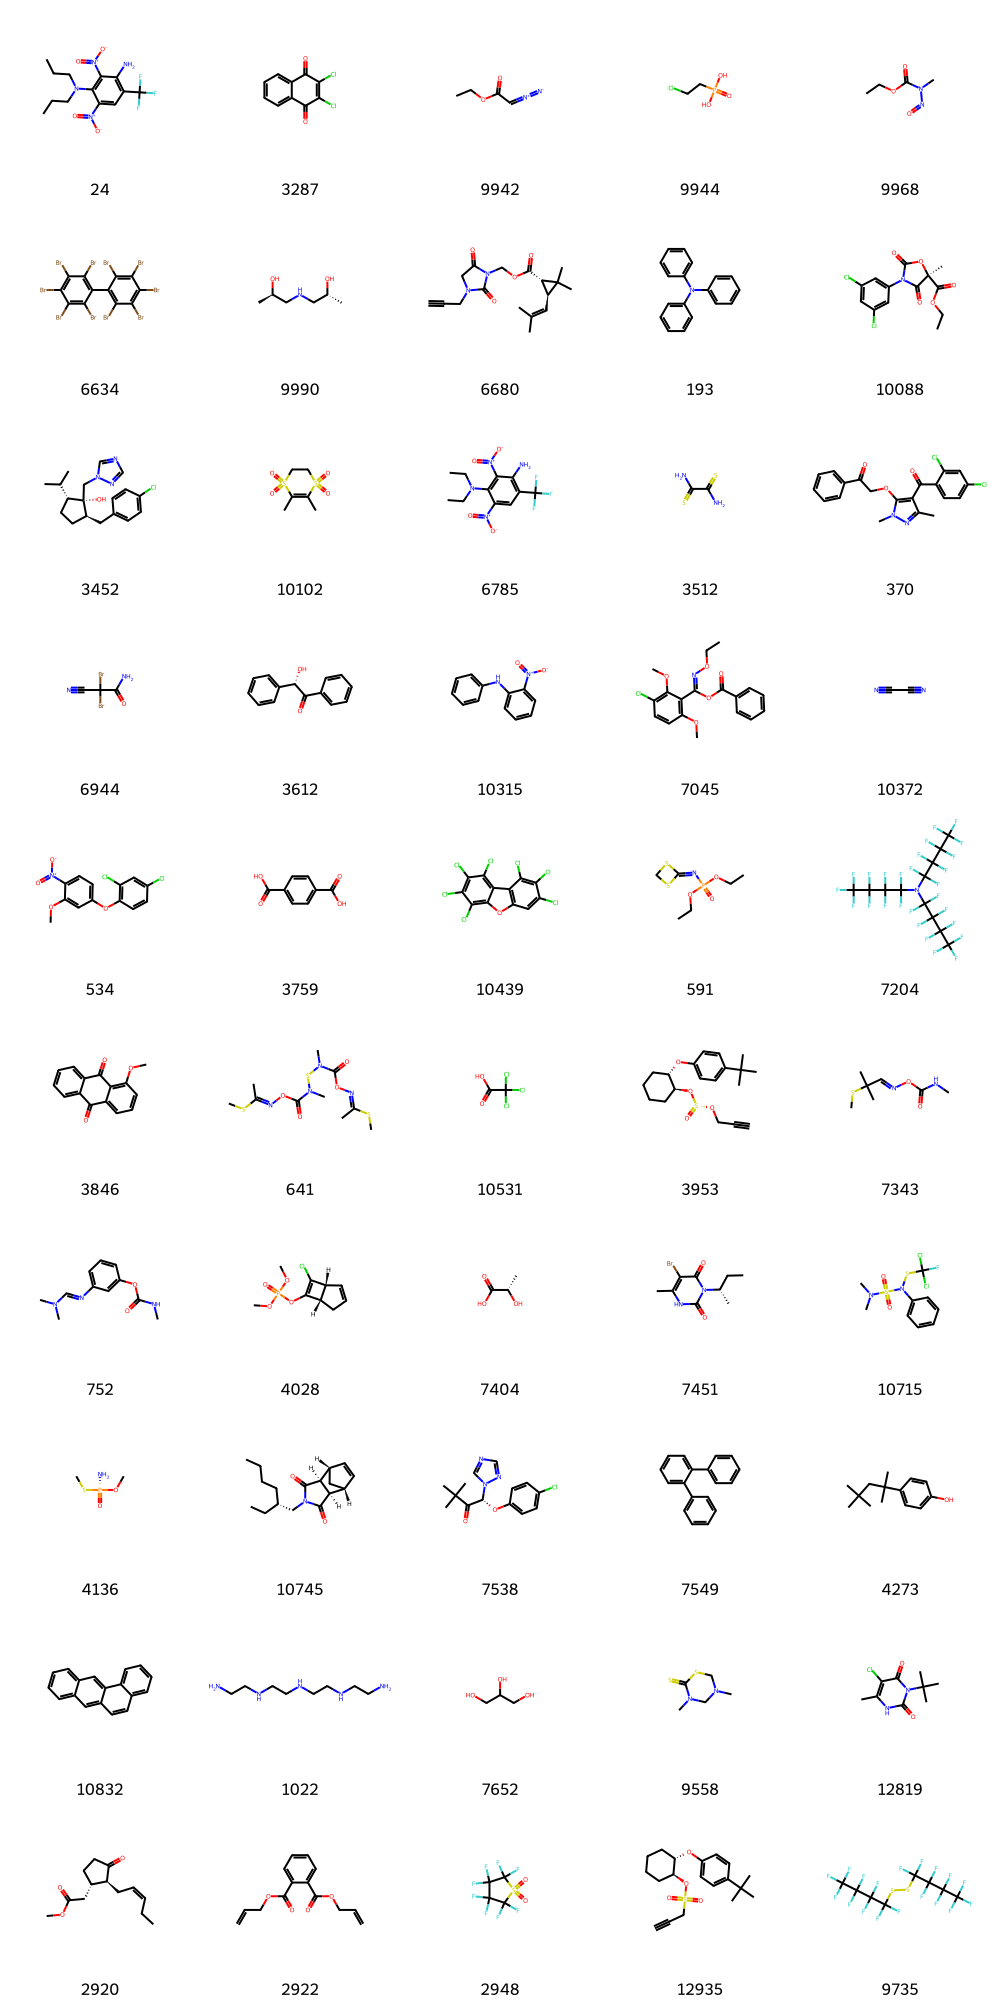

In [187]:
#get the mols where MDFP performs better, error is at least 1 log unit smaller
mrnos_mdfp_better = df_preds_avg[df_preds_avg['abs_error_PhysChem'] - df_preds_avg['abs_error_MDFP'] > 1].index
#sort by error difference
#get the molblocks for these, and draw
mols = df[df['molregno'].isin(mrnos_mdfp_better)]['ROMol']
from rdkit.Chem import Draw
#get preds for both, plus ground truth


Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(mrno) for mrno in mols.index])


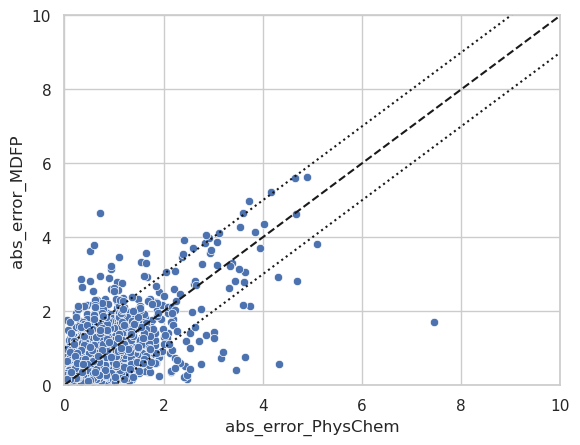

In [166]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
fig, ax = plt.subplots()
sns.scatterplot(x='abs_error_PhysChem', y='abs_error_MDFP', data=df_preds_avg, ax=ax)
ax.plot([0, 10], [0, 10], 'k--')
ax.plot([0, 10], [1, 11], 'k:')
ax.plot([0, 10], [-1, 9], 'k:')
ax.set_xlim(0, 10)
ax.set_ylim(0, 10)
plt.show()

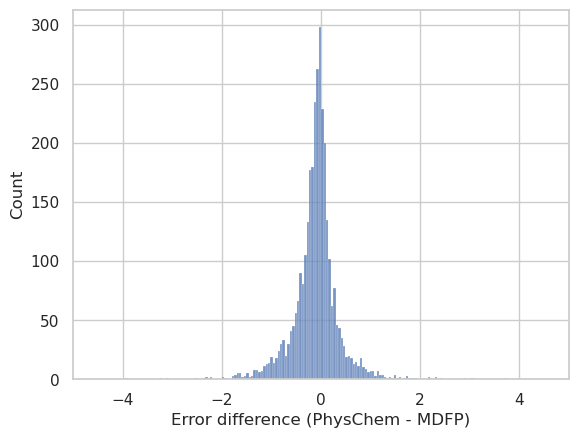

In [194]:
#also make a histogram of the error differences
fig, ax = plt.subplots()
sns.histplot(df_preds_avg['abs_error_PhysChem'] - df_preds_avg['abs_error_MDFP'], kde=False, ax=ax)
#set x label
ax.set_xlabel('Error difference (PhysChem - MDFP)')
ax.set_xlim(-5, 5)
plt.show()

In [182]:

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_single_custom_local(reals, predictions, molregnos, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    rmses, maes, ebos, kts,median_aes = [], [], [], [],[]
    
    for r, p in zip(reals, predictions):
        RMSE, MAE, EBO, KT,median_AE = getStatValues_v2(r, p)
        rmses.append(RMSE)
        maes.append(MAE)
        ebos.append(EBO)
        kts.append(KT)
        median_aes.append(median_AE)
    
    rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
    rmse_mean = np.mean(rmses)
    mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
    mae_mean = np.mean(maes)
    ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
    ebo_mean = np.mean(ebos)
    kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
    kt_mean = np.mean(kts)
    median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
    median_AE_mean = np.mean(median_aes)

    
    # molregno = molregnos[0]
    
    mrn = [item for sublist in molregnos for item in sublist]
    real = [item for sublist in reals for item in sublist]
    prediction = [item for sublist in predictions for item in sublist]
    
    df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
    df = df.groupby('molregno').mean()
    real = df['real'].tolist()
    prediction = df['prediction'].tolist()
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')
    
    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

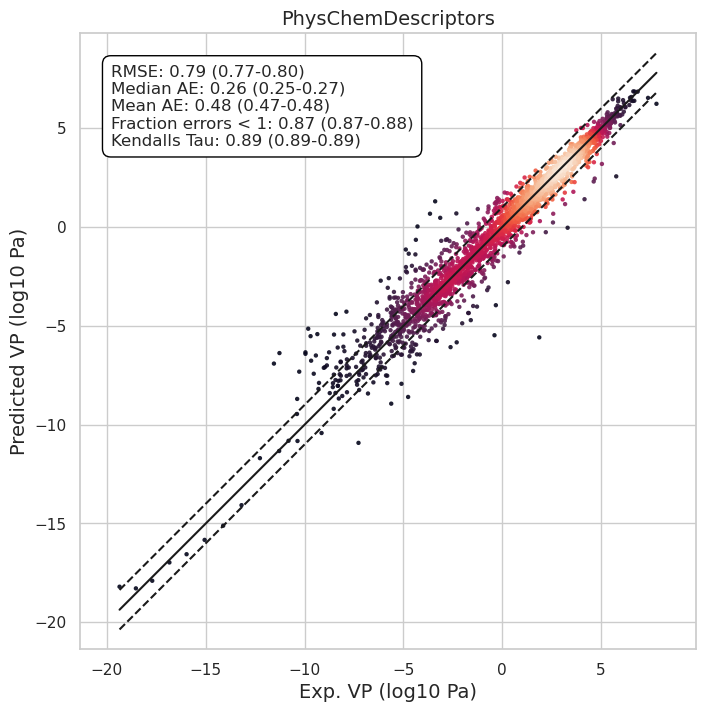

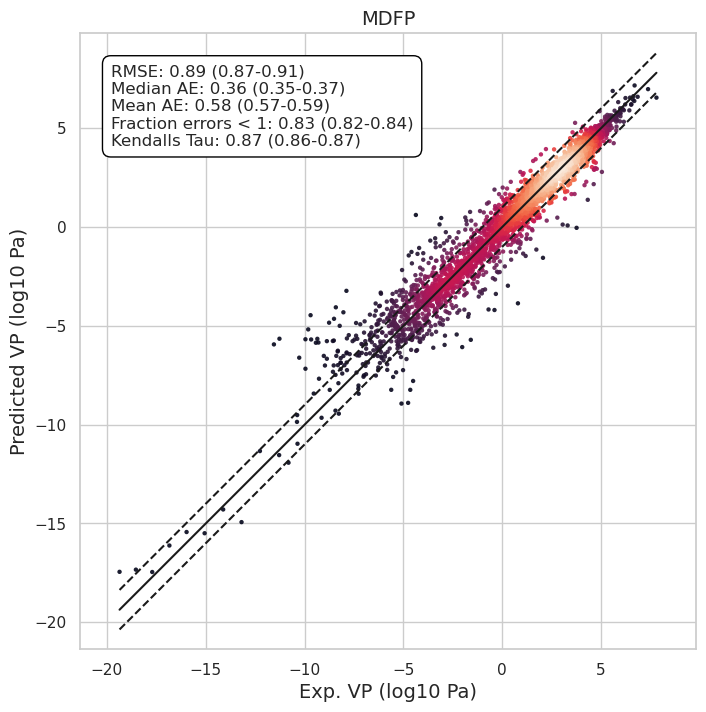

In [186]:
density_plot_single_custom_local(reals = outputs[0], predictions = outputs[1], molregnos = outputs[3], print_stats=True, bounds=None,  print_spearman=False, title='PhysChemDescriptors')
density_plot_single_custom_local(reals = outputs[0], predictions = outputs[2], molregnos = outputs[3], print_stats=True, bounds=None,  print_spearman=False, title='MDFP')


In [190]:
df_test.to_csv('mols_mdfp_physchem_features.csv', index=False)

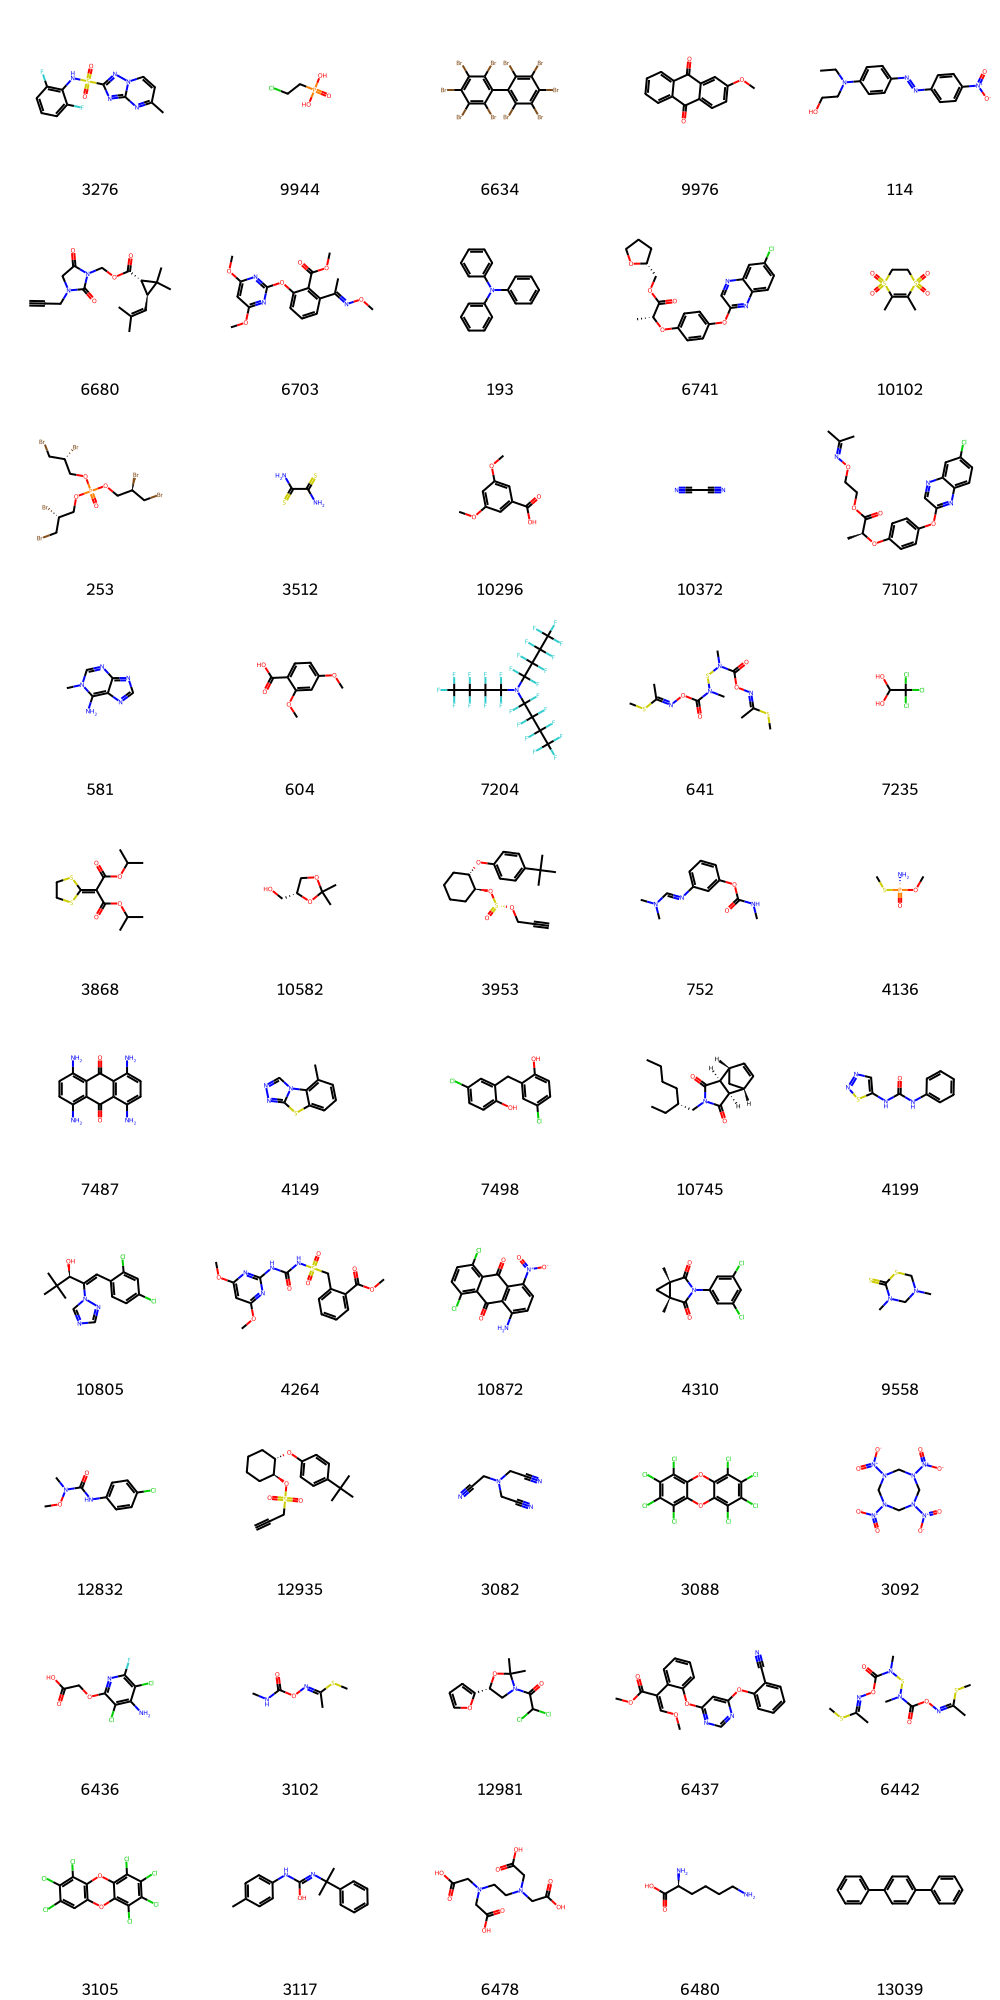

In [195]:
#draw 50 mols with the largest error PhysChem
df_preds_avg.sort_values('abs_error_PhysChem', ascending=False).head(50)
mols = df[df['molregno'].isin(df_preds_avg.sort_values('abs_error_PhysChem', ascending=False).head(50).index)]['ROMol']
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(mrno) for mrno in mols.index])

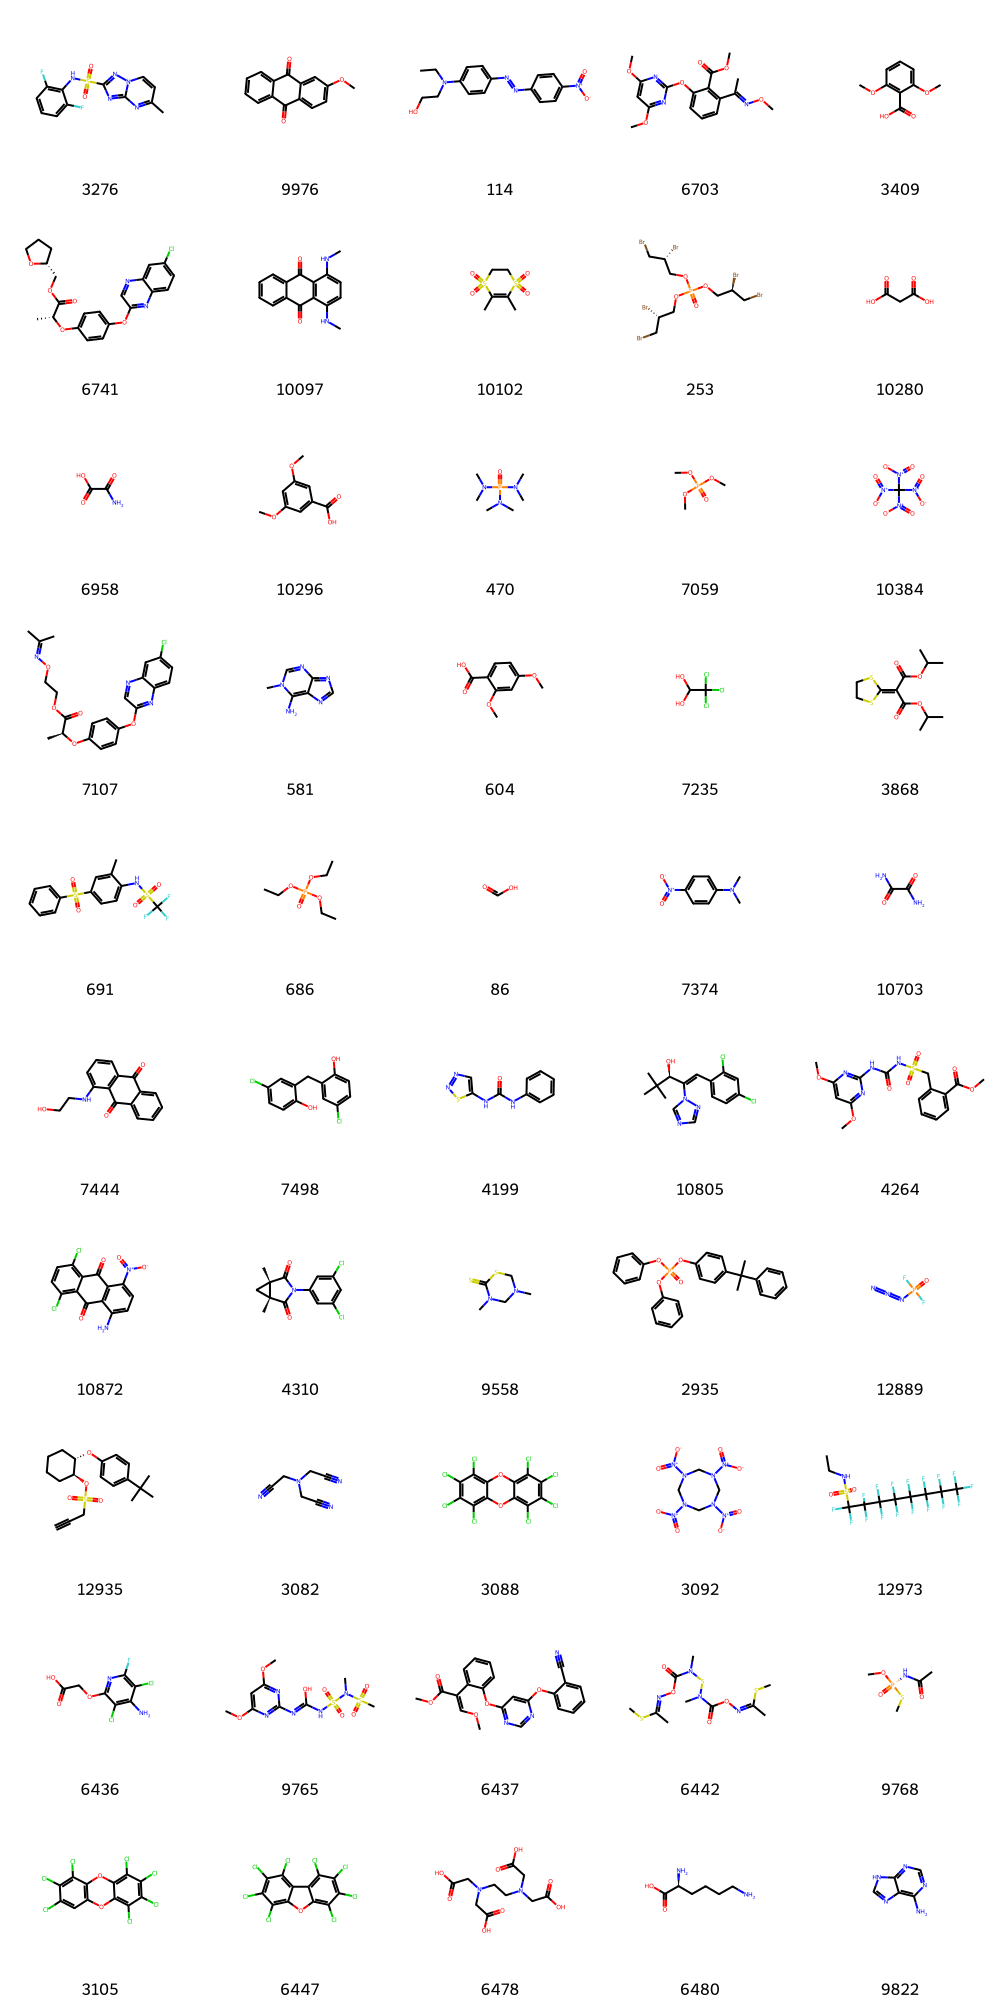

In [196]:
#draw 50 mols with the largest error MDFP
df_preds_avg.sort_values('abs_error_MDFP', ascending=False).head(50)
mols = df[df['molregno'].isin(df_preds_avg.sort_values('abs_error_MDFP', ascending=False).head(50).index)]['ROMol']
Draw.MolsToGridImage(mols, molsPerRow=5, subImgSize=(200, 200), legends=[str(mrno) for mrno in mols.index])

In [198]:
#also try again now to combine
mdfp_features_counts = ['NumHeavyAtoms', 'NumRotatableBonds', 'NumN', 'NumO', 'NumF', 'NumP', 'NumS', 'NumCl', 'NumBr', 'NumI']
mdfp_features_other = [f for f in mdfp_features_all if f not in mdfp_features_counts]
mdfp_features_other


['water_intra_crf_mean',
 'water_intra_crf_std',
 'water_intra_crf_median',
 'water_intra_lj_mean',
 'water_intra_lj_std',
 'water_intra_lj_median',
 'water_total_crf_mean',
 'water_total_crf_std',
 'water_total_crf_median',
 'water_total_lj_mean',
 'water_total_lj_std',
 'water_total_lj_median',
 'water_intra_ene_mean',
 'water_intra_ene_std',
 'water_intra_ene_median',
 'water_total_ene_mean',
 'water_total_ene_std',
 'water_total_ene_median',
 'water_rgyr_mean',
 'water_rgyr_std',
 'water_rgyr_median',
 'water_sasa_mean',
 'water_sasa_std',
 'water_sasa_median']

In [199]:
import pickle
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Disable future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def train_grouped_kfold_local_three(df, params, descriptors_1, descriptors_2, descriptors_3, name='test', split_on='inchi', y='vp_log10pa', n_splits=5, n_repeats=3, random_state=2652124, normalize_x=False):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    X = df[split_on].to_numpy()
    output = ([], [], [], [], [], [], [], [], [], [], [])

    for i, (train_index, test_index) in enumerate(rkf.split(X)):
        train_all = df[df[split_on].isin(X[train_index])]
        test_all = df[df[split_on].isin(X[test_index])]

        # Ensure there is no overlap in inchi between train and test
        assert len(set(train_all[split_on]).intersection(set(test_all[split_on]))) == 0

        train_X_1 = train_all[descriptors_1]
        train_X_2 = train_all[descriptors_2]
        train_X_3 = train_all[descriptors_3]  # Added line for descriptors_3
        train_y = train_all[y]
        test_X_1 = test_all[descriptors_1]
        test_X_2 = test_all[descriptors_2]
        test_X_3 = test_all[descriptors_3]  # Added line for descriptors_3
        test_y = test_all[y]
        inchi_test = test_all[split_on]

        # Assert that there are no duplicate features
        try:
            assert len(train_X_1.columns) == len(set(train_X_1.columns))
            assert len(train_X_2.columns) == len(set(train_X_2.columns))
            assert len(train_X_3.columns) == len(set(train_X_3.columns))  # Added line for descriptors_3
        except:
            # Print duplicates
            print('Duplicates in train_X_1:', train_X_1.columns[train_X_1.columns.duplicated()])
            print('Duplicates in train_X_2:', train_X_2.columns[train_X_2.columns.duplicated()])
            print('Duplicates in train_X_3:', train_X_3.columns[train_X_3.columns.duplicated()])  # Added line for descriptors_3
        
        if normalize_x:
            scaler = StandardScaler()
            train_X_1 = scaler.fit_transform(train_X_1)
            test_X_1 = scaler.transform(test_X_1)
            train_X_2 = scaler.fit_transform(train_X_2)
            test_X_2 = scaler.transform(test_X_2)
            train_X_3 = scaler.fit_transform(train_X_3)  # Added line for descriptors_3
            test_X_3 = scaler.transform(test_X_3)  # Added line for descriptors_3

        dtrain_1 = xgb.DMatrix(train_X_1, label=train_y)
        dtest_1 = xgb.DMatrix(test_X_1, label=test_y)
        model_1 = xgb.train(
            params,
            dtrain_1,
            num_boost_round=999,
            verbose_eval=False
        )
        preds_1 = model_1.predict(dtest_1)

        dtrain_2 = xgb.DMatrix(train_X_2, label=train_y)
        dtest_2 = xgb.DMatrix(test_X_2, label=test_y)
        model_2 = xgb.train(
            params,
            dtrain_2,
            num_boost_round=999,
            verbose_eval=False
        )
        preds_2 = model_2.predict(dtest_2)

        dtrain_3 = xgb.DMatrix(train_X_3, label=train_y)  # Added line for descriptors_3
        dtest_3 = xgb.DMatrix(test_X_3, label=test_y)  # Added line for descriptors_3
        model_3 = xgb.train(
            params,
            dtrain_3,
            num_boost_round=999,
            verbose_eval=False
        )
        preds_3 = model_3.predict(dtest_3)  # Added line for descriptors_3

        output[0].append(test_y.to_list())
        output[1].append(list(preds_1))
        output[2].append(list(preds_2))
        output[3].append(list(preds_3))  # Added line for descriptors_3
        output[4].append(inchi_test.to_list())  # Updated index for inchi_test

        # Print the RMSEs
        rmse_1 = mean_squared_error(test_y, preds_1, squared=False)
        rmse_2 = mean_squared_error(test_y, preds_2, squared=False)
        rmse_3 = mean_squared_error(test_y, preds_3, squared=False)  # Added line for descriptors_3
        print(f"Fold {i + 1}: RMSE_1 = {rmse_1}, RMSE_2 = {rmse_2}, RMSE_3 = {rmse_3}")  # Updated print statement

    with open(f'{name}.pkl', 'wb') as f:
        pickle.dump(output, f)

    return output


In [200]:
outputs_incl_combined = train_grouped_kfold_local_three(df_test, params, list(rdkit_feauture_names), mdfp_features_all, list(rdkit_feauture_names)+mdfp_features_other, name='test', split_on='molregno', y='vp_log10_pa', n_splits=5, n_repeats=3, random_state=2652124, normalize_x=False)

Fold 1: RMSE_1 = 0.7838869169756383, RMSE_2 = 0.958942939016837, RMSE_3 = 0.7964097179200991
Fold 2: RMSE_1 = 0.7453739965040213, RMSE_2 = 0.8237998114604851, RMSE_3 = 0.7203228124620172
Fold 3: RMSE_1 = 0.7643193650747029, RMSE_2 = 0.8897325758504292, RMSE_3 = 0.8137889562568712
Fold 4: RMSE_1 = 0.8241253562528105, RMSE_2 = 0.8646253209975955, RMSE_3 = 0.8527935975927525
Fold 5: RMSE_1 = 0.7997997621830879, RMSE_2 = 0.885953545639177, RMSE_3 = 0.8094687362122152
Fold 6: RMSE_1 = 0.7795007651984082, RMSE_2 = 0.8858001761737367, RMSE_3 = 0.7696553853490572
Fold 7: RMSE_1 = 0.7656685257161759, RMSE_2 = 0.9431322585023101, RMSE_3 = 0.7774879682905296
Fold 8: RMSE_1 = 0.820669887247766, RMSE_2 = 0.8075174544960394, RMSE_3 = 0.8378058419996144
Fold 9: RMSE_1 = 0.8730424875226664, RMSE_2 = 0.9398069077277573, RMSE_3 = 0.8806661726935422
Fold 10: RMSE_1 = 0.7394714979965691, RMSE_2 = 0.8118814576569462, RMSE_3 = 0.7655235349061048
Fold 11: RMSE_1 = 0.8260227866680397, RMSE_2 = 0.9322839811965

In [201]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

def density_plot_multiple_custom_local(reals_list, predictions_list, molregnos_list, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    fig, axes = plt.subplots(1, len(reals_list), figsize=(10 * len(reals_list), 8))

    for i, (reals, predictions, molregnos) in enumerate(zip(reals_list, predictions_list, molregnos_list)):
        ax = axes[i] if len(reals_list) > 1 else axes

        rmses, maes, ebos, kts, median_aes = [], [], [], [], []

        for r, p in zip(reals, predictions):
            RMSE, MAE, EBO, KT, median_AE = getStatValues_v2(r, p)
            rmses.append(RMSE)
            maes.append(MAE)
            ebos.append(EBO)
            kts.append(KT)
            median_aes.append(median_AE)

        rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
        rmse_mean = np.mean(rmses)
        mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
        mae_mean = np.mean(maes)
        ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
        ebo_mean = np.mean(ebos)
        kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
        kt_mean = np.mean(kts)
        median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
        median_AE_mean = np.mean(median_aes)

        mrn = [item for sublist in molregnos for item in sublist]
        real = [item for sublist in reals for item in sublist]
        prediction = [item for sublist in predictions for item in sublist]

        df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
        df = df.groupby('molregno').mean()
        real = df['real'].tolist()
        prediction = df['prediction'].tolist()

        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
        ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

        dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
        z = dens_u.pdf([real, prediction])

        sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)

        ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
        ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
        ax.grid(True, which="both")

        if bounds is None:
            lower = min(prediction + real) - 2
            upper = max(prediction + real) + 2
        else:
            lower = bounds[0]
            upper = bounds[1]

        ax.axis([lower, upper, lower, upper])

        text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})',
                           transform=ax.transAxes, fontsize=12, verticalalignment='top',
                           bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

        if title is not None:
            ax.set_title(title[i] if len(reals_list) > 1 else title, fontsize=14)

        ax.set_aspect('equal', 'box')

    if name:
        plt.savefig(name + '.png', dpi=600)

    plt.show()


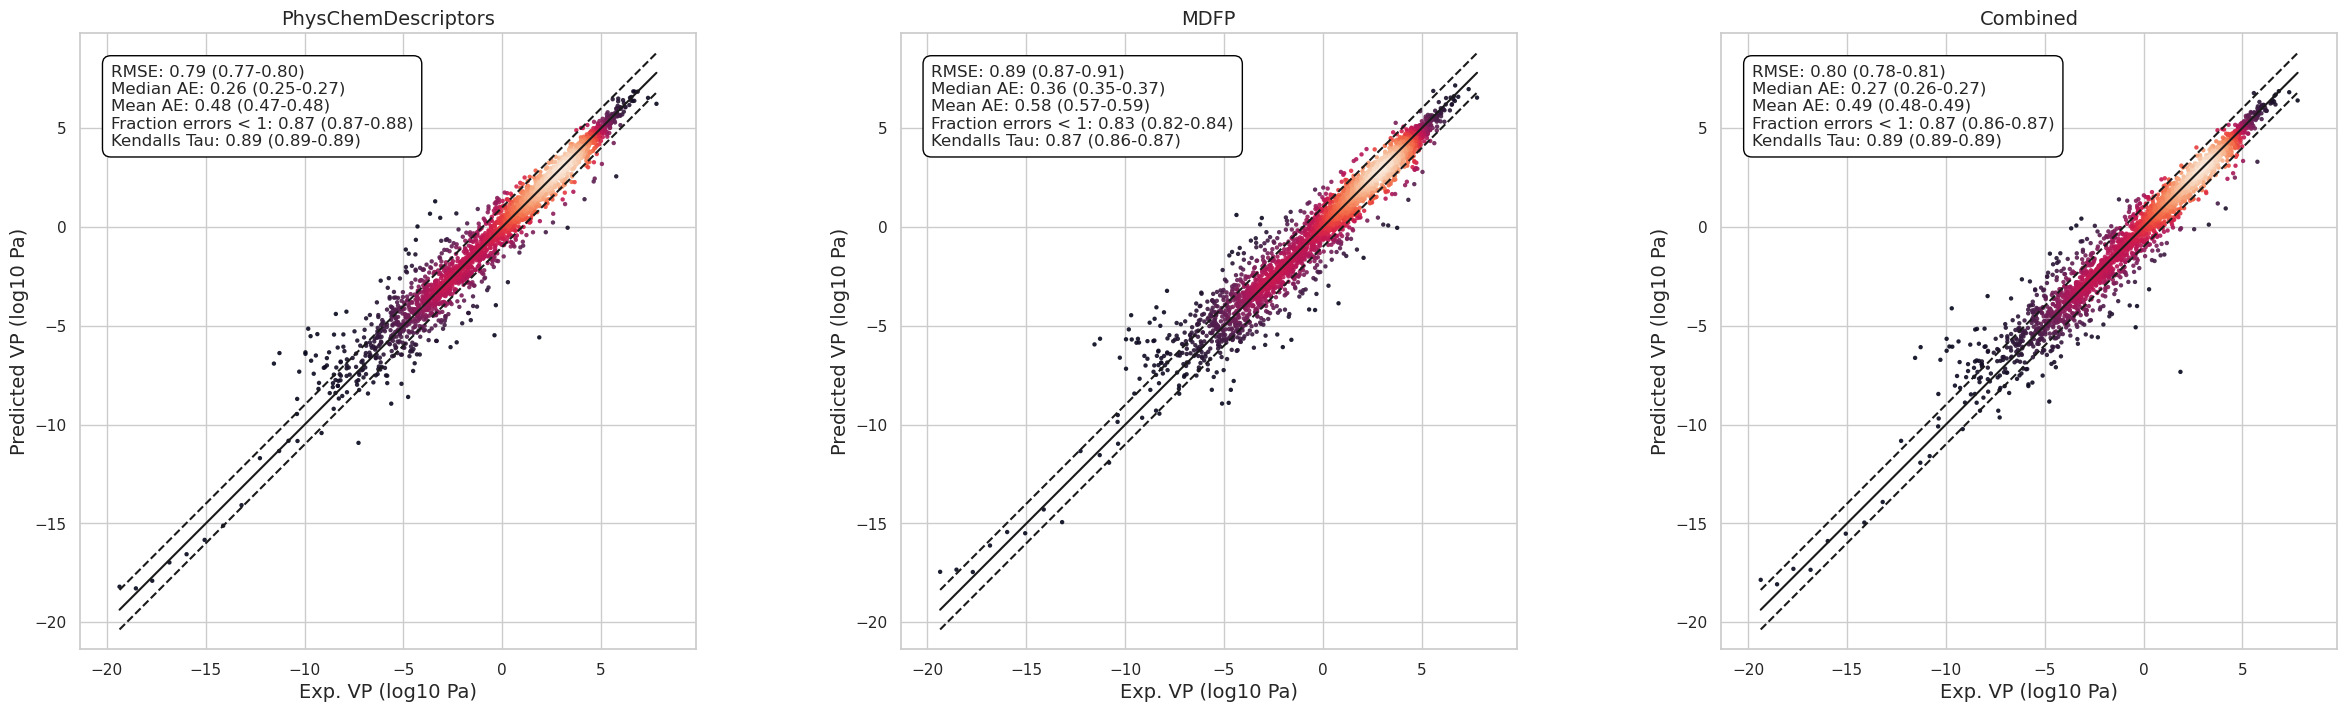

In [202]:
density_plot_multiple_custom_local(reals_list=[outputs_incl_combined[0], outputs_incl_combined[0], outputs_incl_combined[0]], predictions_list=[outputs_incl_combined[1], outputs_incl_combined[2], outputs_incl_combined[3]], molregnos_list=[outputs_incl_combined[4], outputs_incl_combined[4], outputs_incl_combined[4]], print_stats=True, bounds=None, title=['PhysChemDescriptors', 'MDFP', 'Combined'], print_spearman=False, name='combined')